## Разработать модель(и) машинного обучения для прогнозирования ежедневного GMV (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE

## Что нужно сделать:
* Исследовательский анализ данных (EDA).
* Подготовка данных и генерация признаков (Feature Engineering).
* Выбор и обучение модели.
* Оценка качества прогнозов.

### Исследовательский анализ данных (EDA)

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('../data/daily_sales_metrics.csv', parse_dates=['date'])
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## Проверим типы и целостность данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1095 non-null   datetime64[ns]
 1   gmv              1095 non-null   int64         
 2   orders           1095 non-null   int64         
 3   sessions         1095 non-null   int64         
 4   marketing_spend  1095 non-null   int64         
 5   is_promo_active  1095 non-null   int64         
 6   day_of_week      1095 non-null   int64         
 7   day_of_year      1095 non-null   int64         
 8   week_of_year     1095 non-null   int64         
 9   month            1095 non-null   int64         
 10  year             1095 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 94.2 KB


In [4]:
df.isna().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

## Построим графики для выявления сезонности

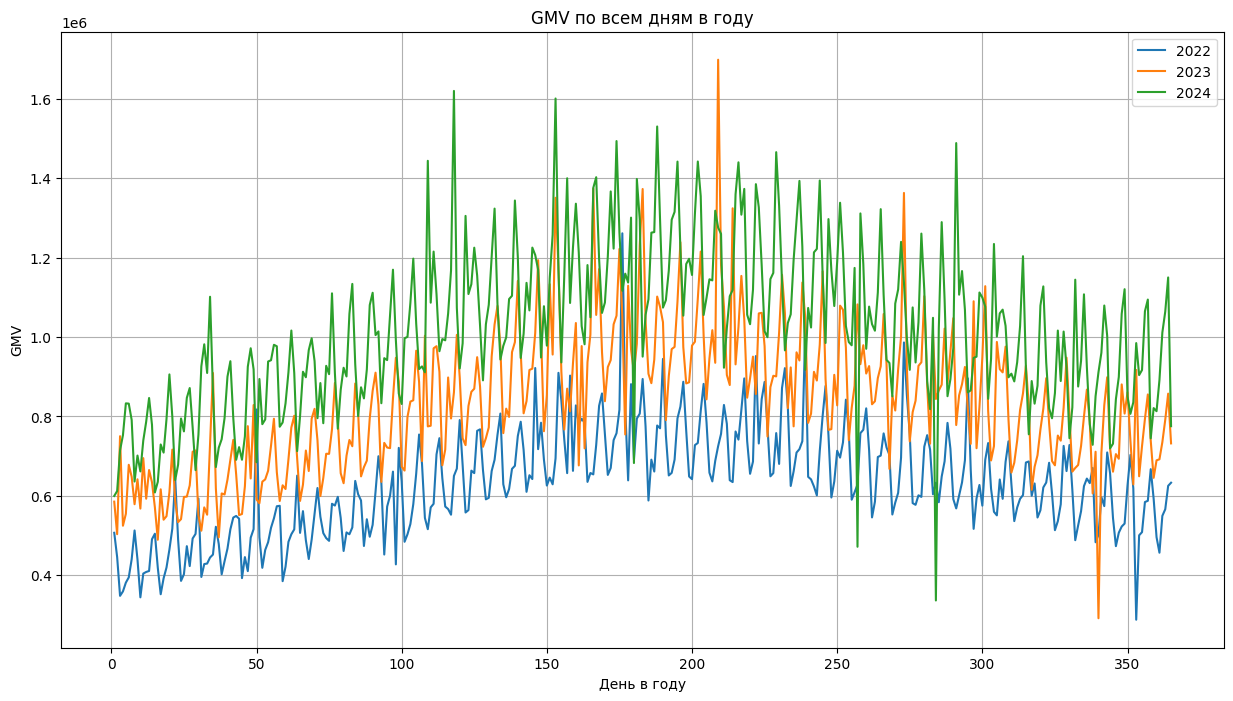

In [6]:
gmv_by_year = df[['year', 'day_of_year', 'gmv']]

plt.figure(figsize=(15, 8))

for year in (2022, 2023, 2024):
    sub = gmv_by_year[gmv_by_year.year == year]
    plt.plot(
        sub.day_of_year,
        sub.gmv,
        label=year
    )

plt.title('GMV по всем дням в году')
plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.grid()
plt.show()

## С учётом крупных промо-акций

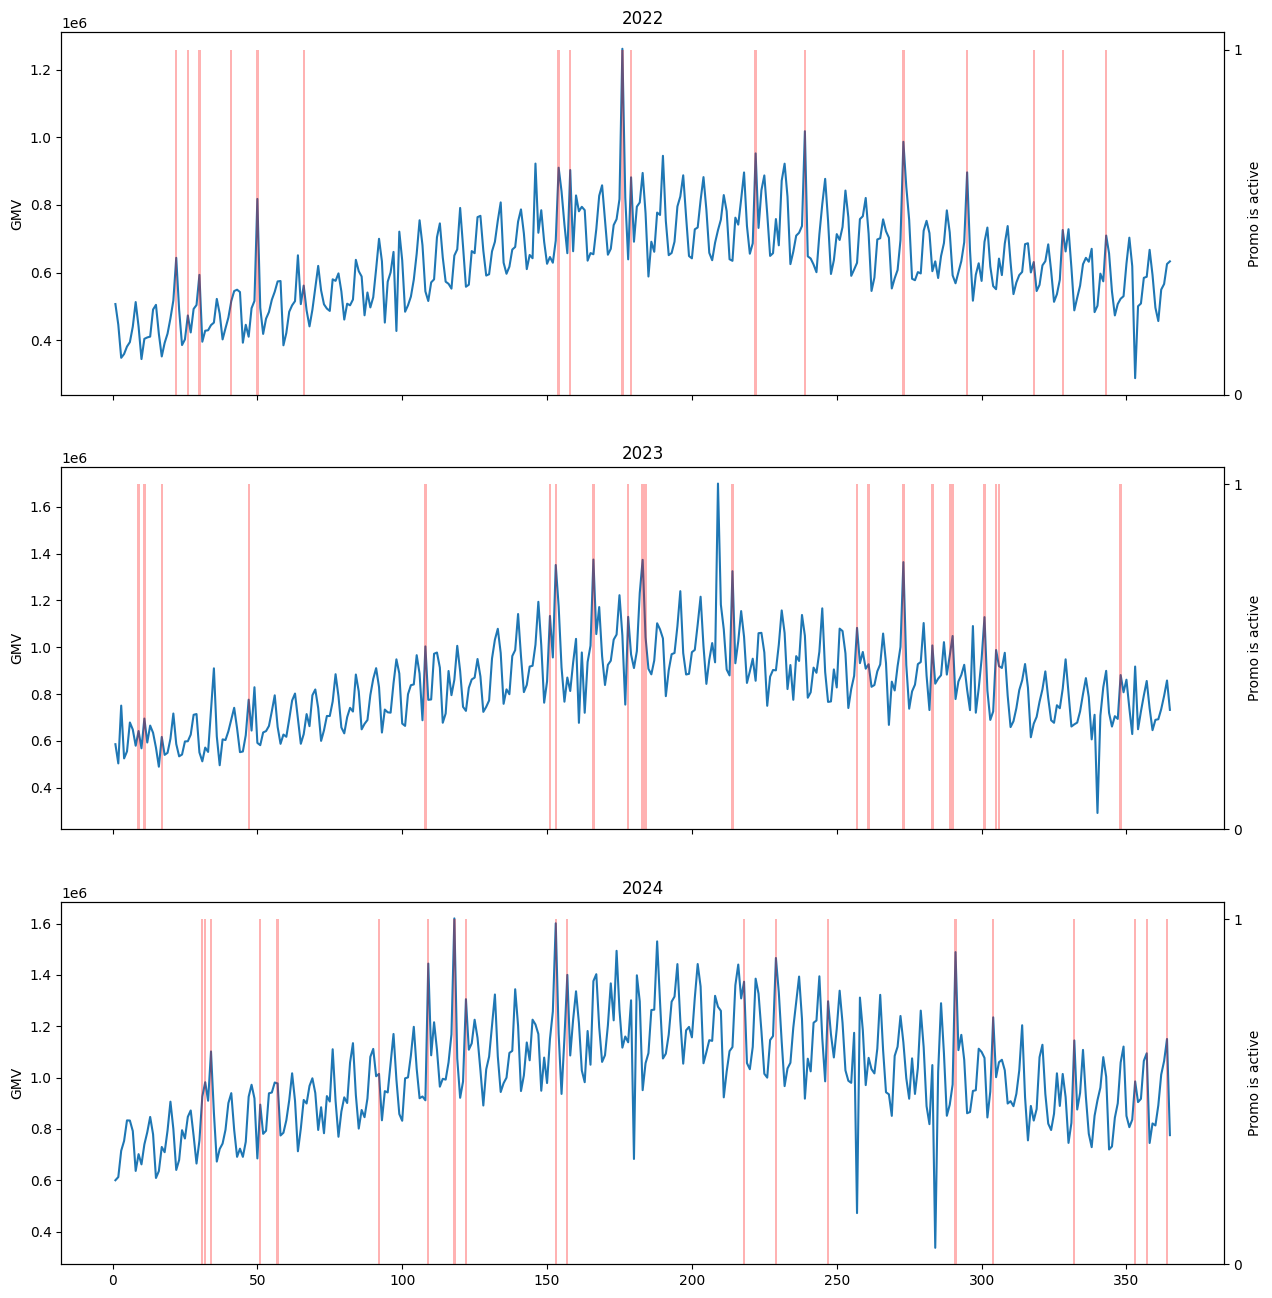

In [39]:
gmv_by_year = df[['year', 'day_of_year', 'gmv', 'is_promo_active']]
years = (2022, 2023, 2024)

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = gmv_by_year[gmv_by_year.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## С учётом масштабов промо

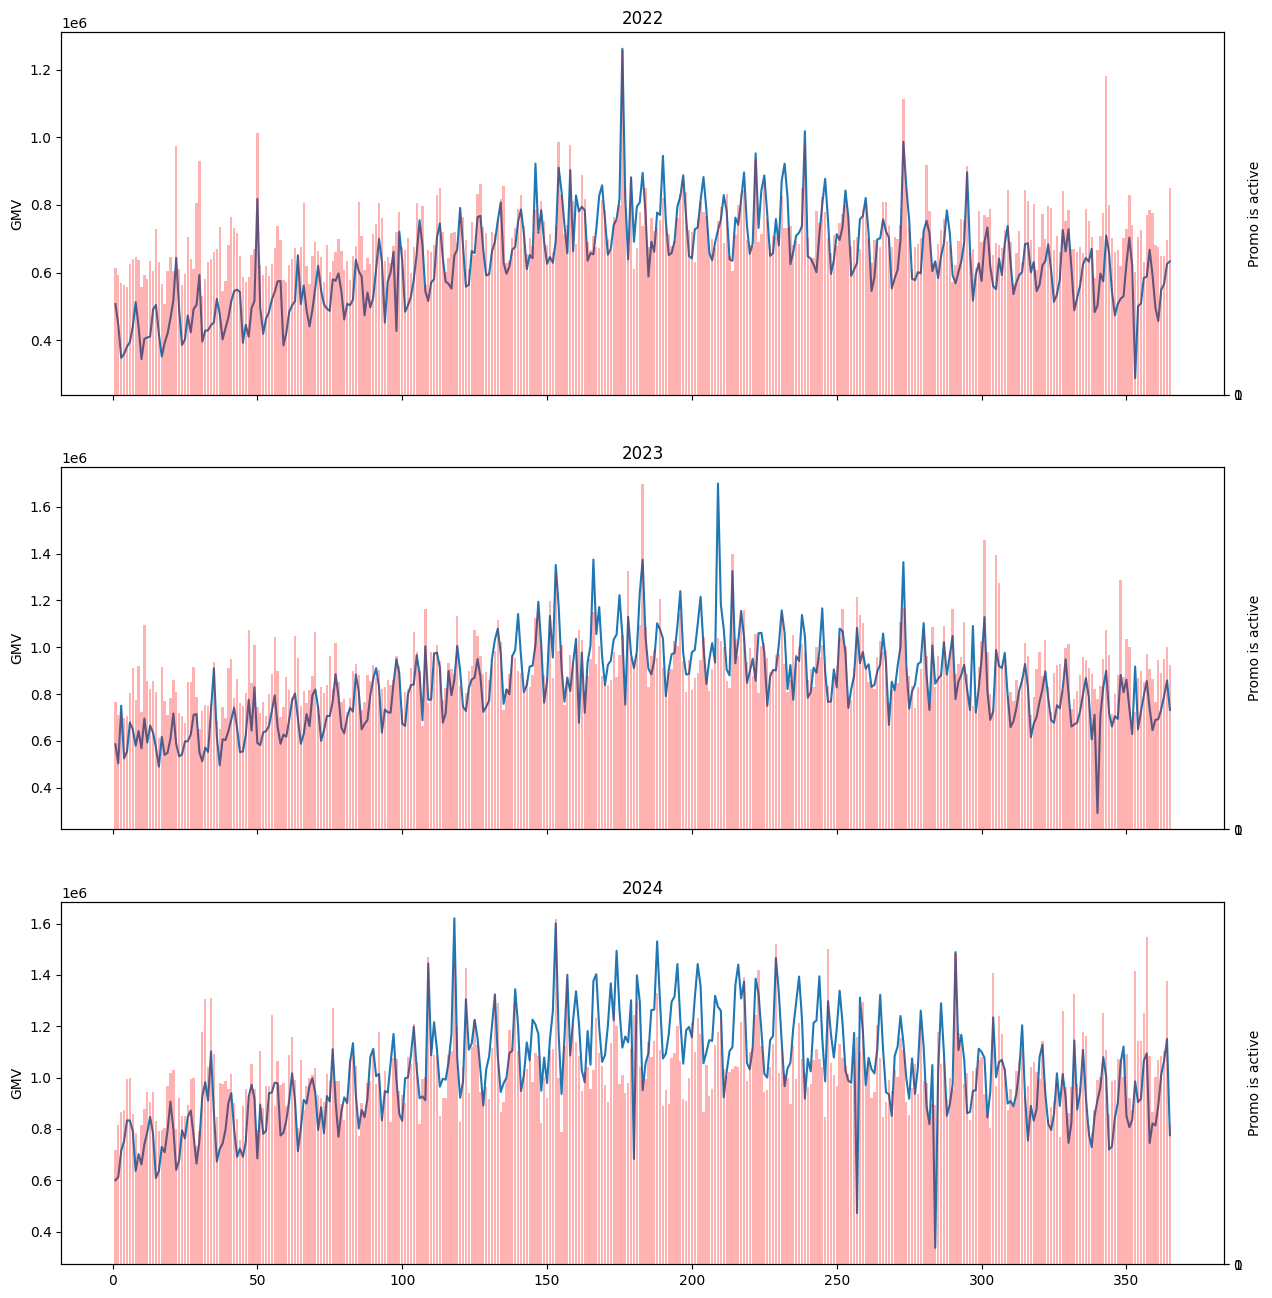

In [41]:
gmv_by_year = df[['year', 'day_of_year', 'gmv', 'marketing_spend']]
years = (2022, 2023, 2024)

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = gmv_by_year[gmv_by_year.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## Боксплоты, показывающие сезонность по дням неделям

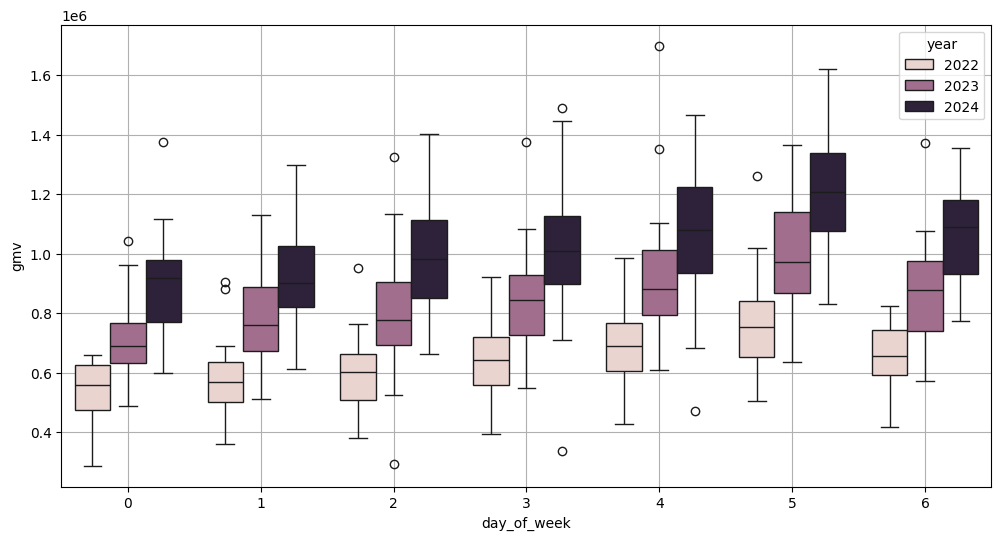

In [69]:
gmv_by_week = df[['gmv', 'day_of_week', 'year']]

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=gmv_by_week,
    x='day_of_week',
    y='gmv',
    hue='year',
)

plt.grid()

In [76]:
gmv_by_week.groupby(['year', 'day_of_week']).gmv.head()

0       506994
1       445834
2       348150
3       359418
4       381439
        ...   
760     926323
761     981861
762     909615
763    1101622
764     862465
Name: gmv, Length: 105, dtype: int64